In [1]:
!pip install catboost

In [2]:
!pip install pystan==2.19.1.1 prophet==1.1.4

  Using cached pystan-2.19.1.1.tar.gz (16.2 MB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 32.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 35.5 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pystan
  Running setup.py clean for pystan
  Created wheel for pymeeus: filename=PyMeeus-0.5.12-py3-none-any.whl size=732000 sha256=90245ccf5f748ee0682f62ed63aee6c609cff1c0d6c58768b3a39c082e1fee70
  Stored in directory: /root/.cache/pip/wheels/8f/bd/f9/5c4c39b529e0322b08979e1c465e203218b

In [2]:
!pip install pmdarima

  Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (7.8 kB)
Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (2.2 MB)


In [ ]:
import os
os.kill(os.getpid(), 9)


In [2]:
!pip install --upgrade numpy

  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.


In [5]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import tqdm
from tqdm.auto import tqdm
import itertools
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from prophet import Prophet
#from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [6]:
df = pd.read_csv("brent-daily.csv", header=None)
df

,0,1
0,Date,Price
1,1987-05-20,18.63
2,1987-05-21,18.45
3,1987-05-22,18.55
4,1987-05-25,18.6
...,...,...
9627,2025-04-28,66.13
9628,2025-04-29,64.04
9629,2025-04-30,63.37
9630,2025-05-01,62.37


In [7]:
def get_data_from_EIA_local():
    df = pd.read_csv("brent-daily.csv", header=0)
    df = df[['Date', 'Price']]
    df['Date'] = pd.to_datetime(df['Date'])
    df['Price'] = df['Price'].astype(float)
    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True)
    return df


def make_future_dates(last_date, period):
    prediction_dates=pd.date_range(last_date, periods=period+1, freq='B')
    return prediction_dates[1:]

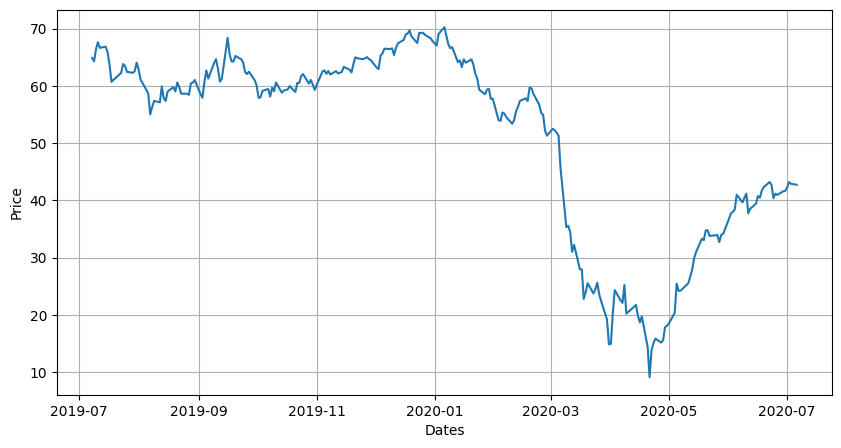

In [8]:
df=get_data_from_EIA_local()
data=df['2019-07-06':'2020-07-06'].copy()
data.Price["2020-04-20"]=(data.Price["2020-04-17"] + data.Price["2020-04-21"]) / 2

acc_sum=[]
df_preds=pd.DataFrame({"Date":make_future_dates('2020-07-06',34)})
df_preds=df_preds.set_index('Date', drop=True)

plt.figure(figsize=(10,5))
plt.xlabel('Dates')
plt.ylabel('Price')
plt.plot(data['Price']);
plt.grid(True)
plt.show()

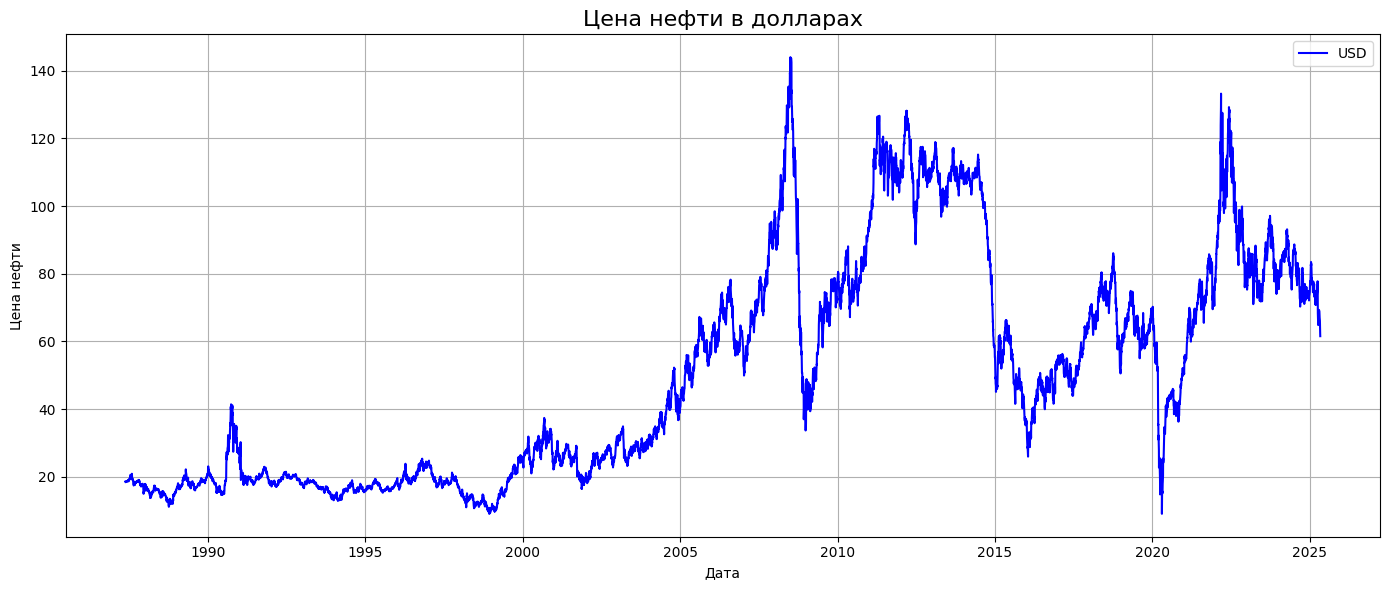

In [9]:
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Price'], label='USD', color='blue')

# Настройки графика
plt.title('Цена нефти в долларах', fontsize=16)
plt.xlabel('Дата')
plt.ylabel('Цена нефти')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
df

,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63
...,...
2025-04-28,66.13
2025-04-29,64.04
2025-04-30,63.37


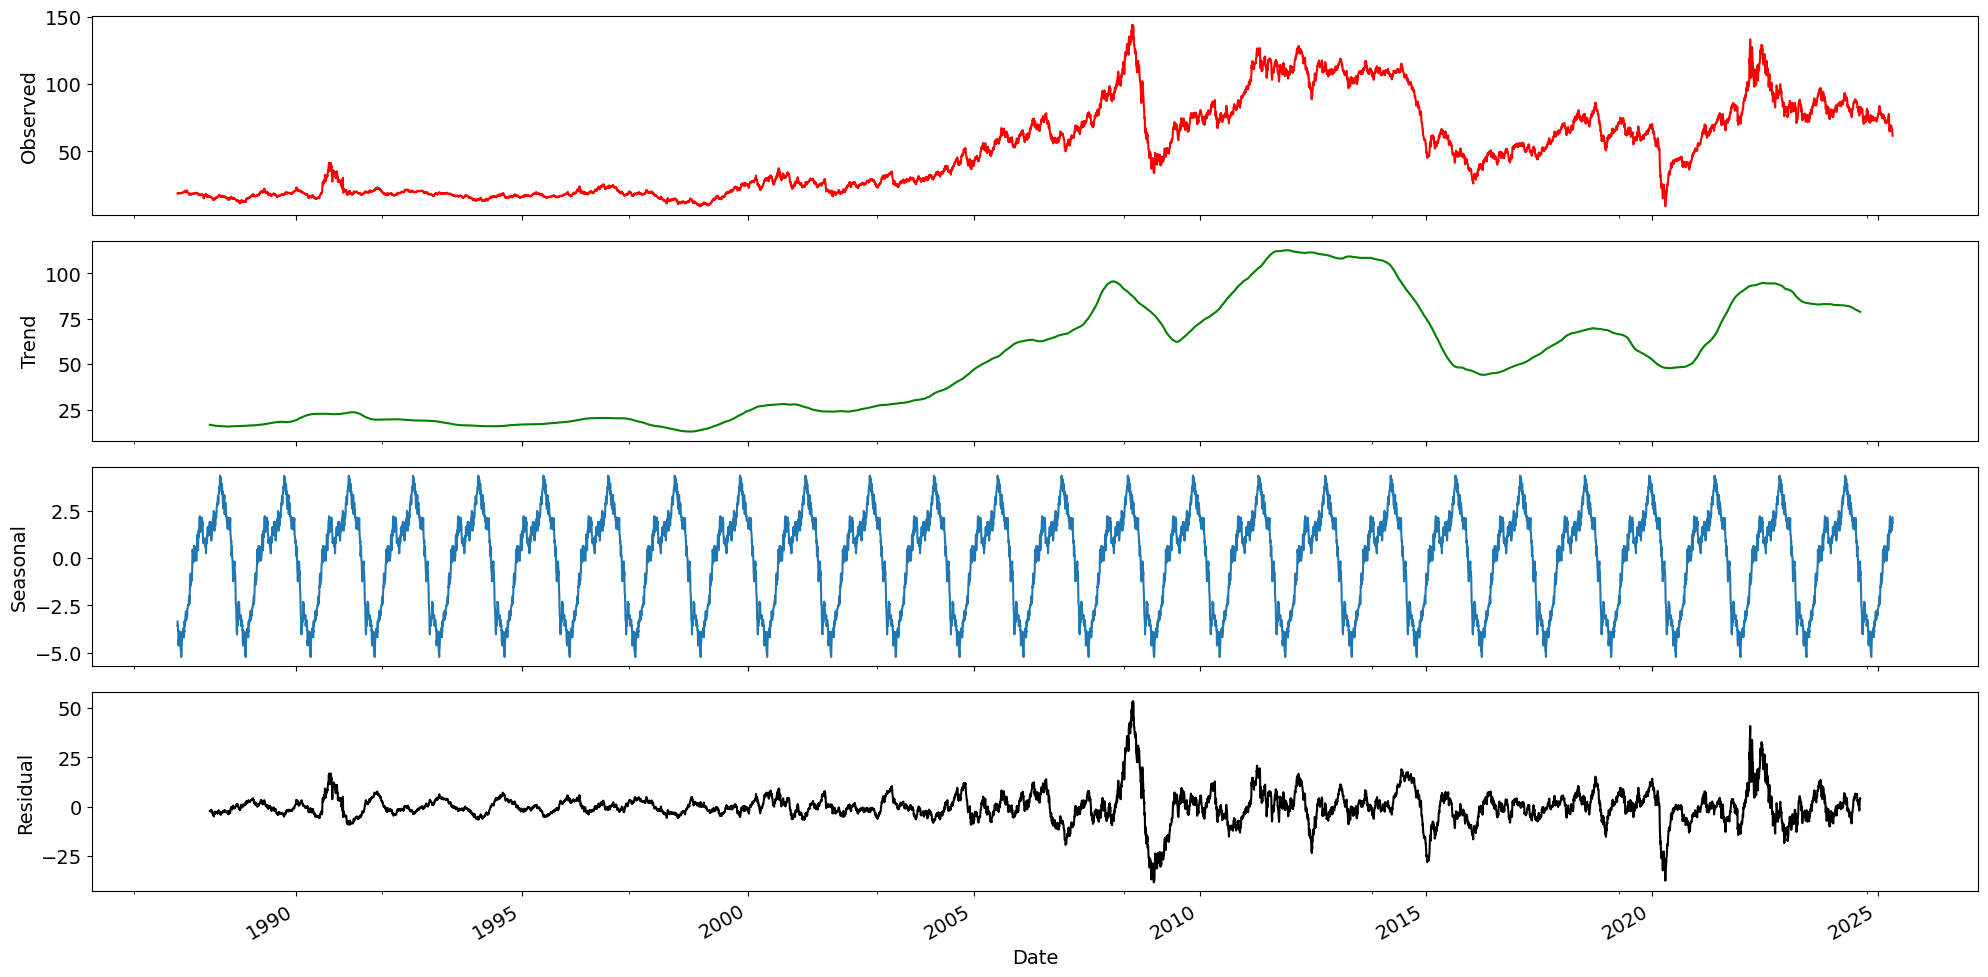

In [11]:
plt.rcParams['font.size'] = 14
plt.rcParams["figure.figsize"] = (20, 10)

res = sm.tsa.seasonal_decompose(df['Price'], model='additive', period=365)

fig, axes = plt.subplots(4, 1, sharex=True)
res.observed.plot(ax=axes[0], legend=False, color='r')
axes[0].set_ylabel('Observed')

res.trend.plot(ax=axes[1], legend=False, color='g')
axes[1].set_ylabel('Trend')

res.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')

res.resid.plot(ax=axes[3], legend=False, color='k')
axes[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

In [12]:
df.index = pd.to_datetime(df.index)
df = df.sort_index()
df['Price_MA7'] = df['Price'].rolling(window=7).mean()
df['Price_MA30'] = df['Price'].rolling(window=30).mean()
df['Price_STD7'] = df['Price'].rolling(window=7).std()
df['Price_diff1'] = df['Price'].diff()
df['Return'] = df['Price'].pct_change()
df['Price_lag1'] = df['Price'].shift(1)
df['Price_lag7'] = df['Price'].shift(7)
df['Month'] = df.index.month
df['DayOfWeek'] = df.index.dayofweek

In [13]:
df

,Price,Price_MA7,Price_MA30,Price_STD7,Price_diff1,Return,Price_lag1,Price_lag7,Month,DayOfWeek
Date,,,,,,,,,,
1987-05-20,18.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,2
1987-05-21,18.45,NaN,NaN,NaN,-0.18,-0.009662,18.63,NaN,5,3
1987-05-22,18.55,NaN,NaN,NaN,0.10,0.005420,18.45,NaN,5,4
1987-05-25,18.60,NaN,NaN,NaN,0.05,0.002695,18.55,NaN,5,0
1987-05-26,18.63,NaN,NaN,NaN,0.03,0.001613,18.60,NaN,5,1
...,...,...,...,...,...,...,...,...,...,...
2025-04-28,66.13,67.868571,70.575000,1.106879,-0.86,-0.012838,66.99,66.58,4,0
2025-04-29,64.04,67.311429,70.311667,1.818016,-2.09,-0.031604,66.13,67.94,4,1
2025-04-30,63.37,66.460000,70.026333,2.090327,-0.67,-0.010462,64.04,69.33,4,2


In [14]:
df = df.dropna()
total_len = len(df)
train_size = int(total_len * 0.7)

train = df.iloc[:train_size]
test = df.iloc[train_size:]

In [15]:
features = ['Price_lag1', 'Price_MA7', 'Price_STD7', 'Return', 'DayOfWeek', 'Month']
X_train = train[features]
X_test = test[features]
y_train = train['Price']
y_test = test['Price']

In [16]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

In [17]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [18]:
cb_model = CatBoostRegressor(verbose=0, random_state=42)
cb_model.fit(X_train, y_train)
y_pred_cb = cb_model.predict(X_test)

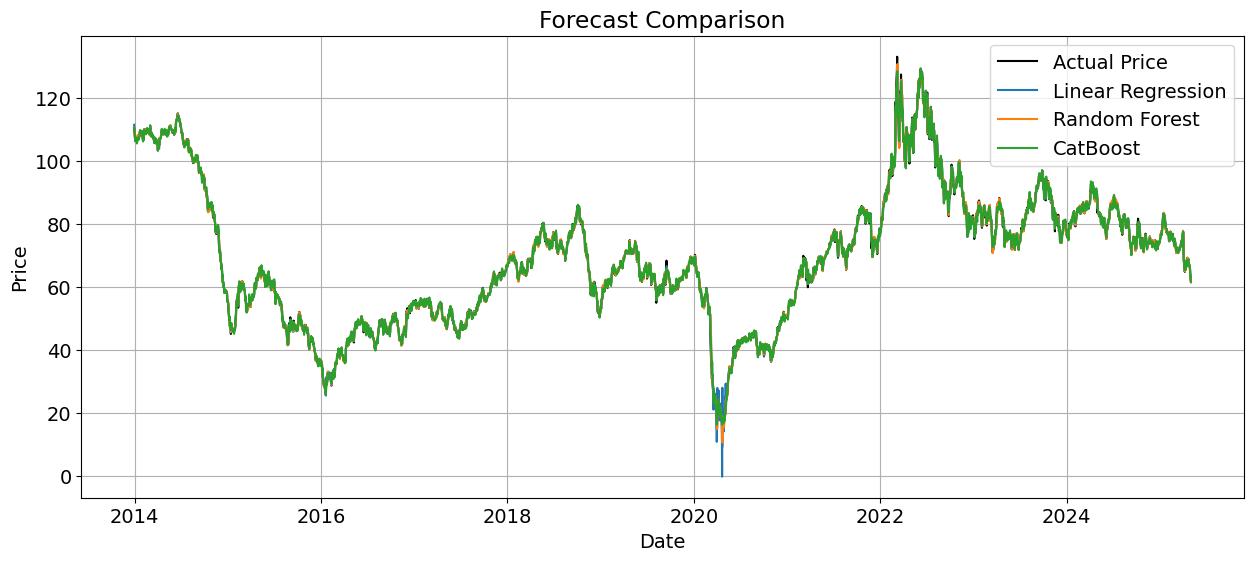

In [19]:
plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test, label='Actual Price', color='black')
plt.plot(y_test.index, y_pred_lr, label='Linear Regression')
plt.plot(y_test.index, y_pred_rf, label='Random Forest')
plt.plot(y_test.index, y_pred_cb, label='CatBoost')
plt.title('Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
def evaluate(y_true, y_pred):
    return {
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAE': mean_absolute_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred)
    }

metrics = {
    'Linear Regression': evaluate(y_test, y_pred_lr),
    'Random Forest': evaluate(y_test, y_pred_rf),
    'CatBoost': evaluate(y_test, y_pred_cb)
}

metrics_df = pd.DataFrame(metrics).T
metrics_df

,RMSE,MAE,R2
Linear Regression,0.921600,0.521026,0.998088
Random Forest,0.701175,0.314800,0.998893
CatBoost,0.657926,0.457519,0.999026


In [21]:
df_decomp = df[['Price']].dropna()
df_decomp = df_decomp.asfreq('D')
df_decomp = df_decomp.fillna(method='ffill')

result = seasonal_decompose(df_decomp['Price'], model='additive')

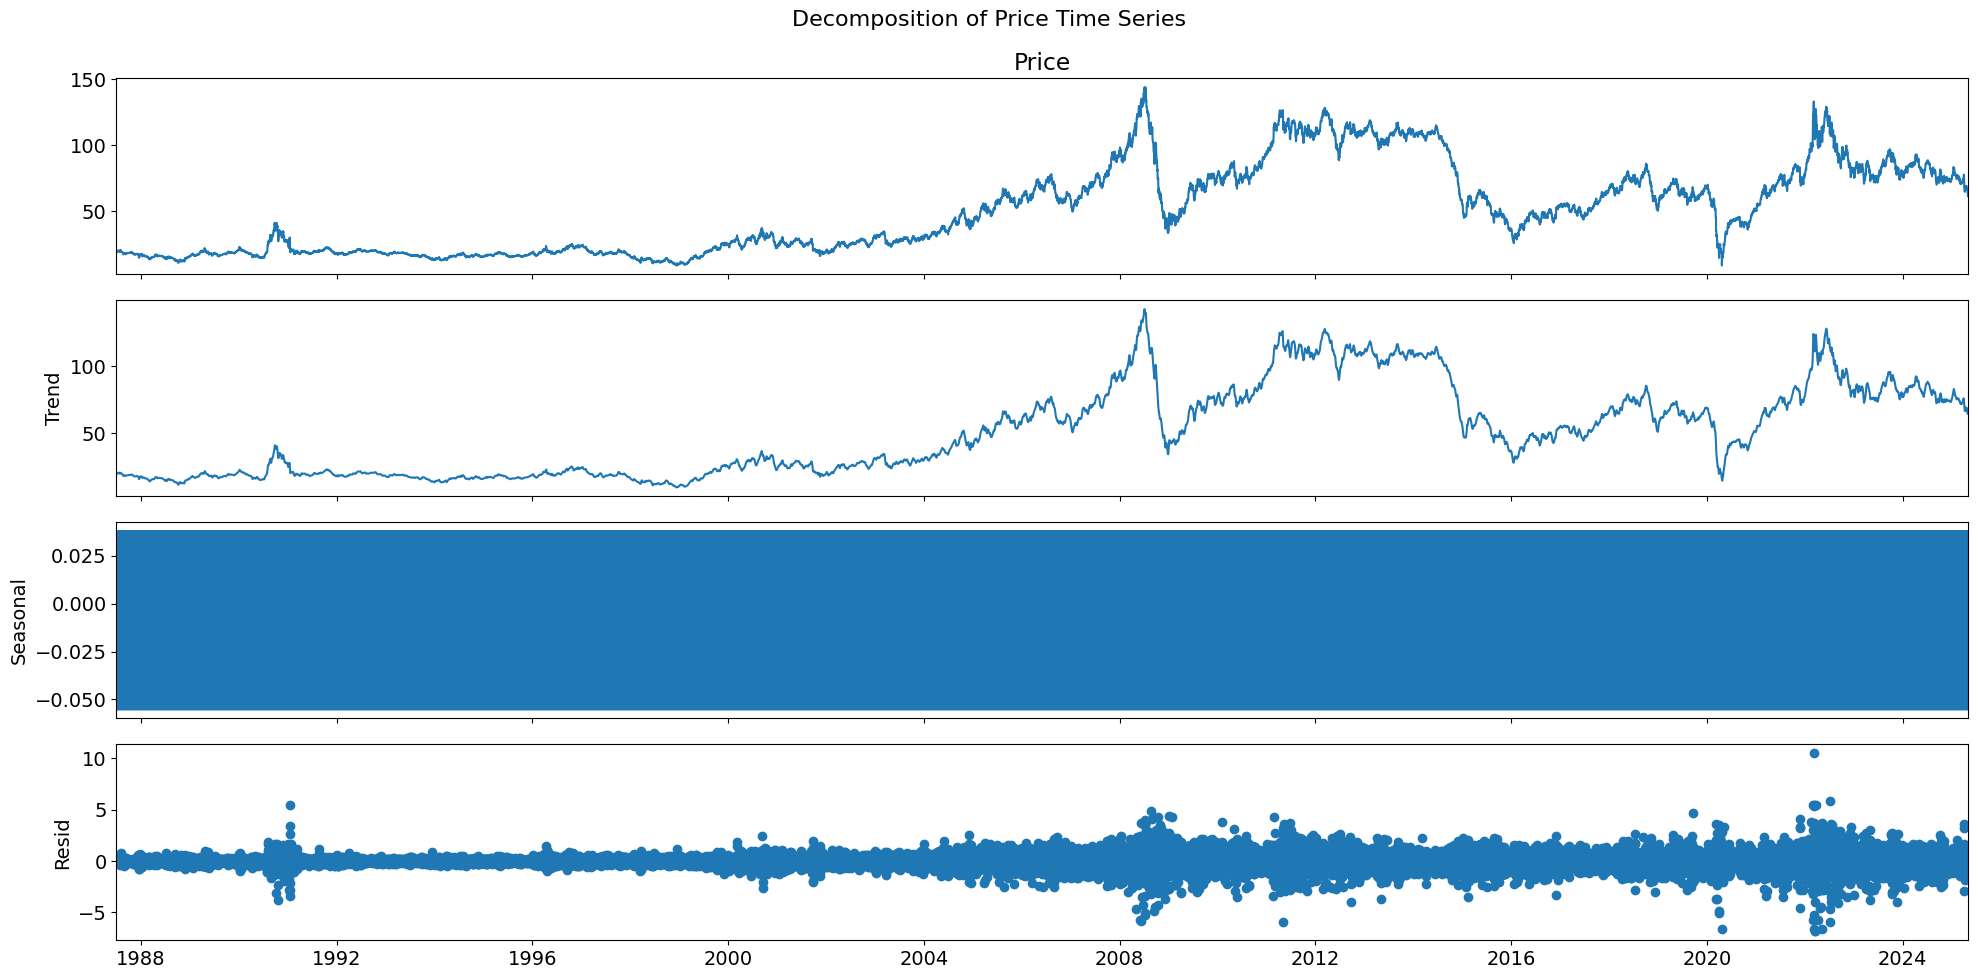

In [22]:
result.plot()
plt.suptitle('Decomposition of Price Time Series', fontsize=16)
plt.tight_layout()
plt.show()

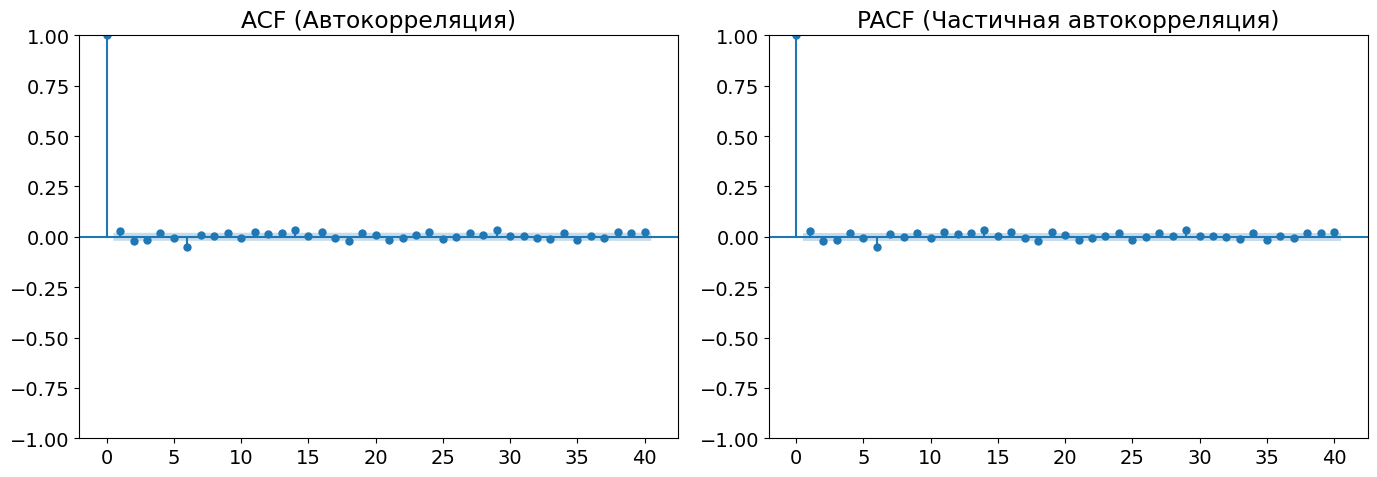

In [23]:
price_diff = df['Price'].diff().dropna()
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_acf(price_diff, lags=40, ax=axes[0])
axes[0].set_title('ACF (Автокорреляция)')

plot_pacf(price_diff, lags=40, ax=axes[1], method='ywm')
axes[1].set_title('PACF (Частичная автокорреляция)')

plt.tight_layout()
plt.show()

In [24]:
def evaluate_model(y_true, y_pred, label):
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f'{label} — RMSE: {rmse:.4f}, MAE: {mae:.4f}')
    return {'label': label, 'rmse': rmse, 'mae': mae}

In [25]:
from statsmodels.tsa.stattools import adfuller

series = df['Price'].dropna()
adf_result = adfuller(series)
print(f'ADF Statistic: {adf_result[0]:.4f}')
print(f'p-value: {adf_result[1]:.4f}')
if adf_result[1] < 0.05:
    print("✅ Ряд стационарен — можно использовать d=0")
    d_param = 0
else:
    print("❌ Ряд нестационарен — используем d=1")
    d_param = 1


ADF Statistic: -2.2637
p-value: 0.1840
❌ Ряд нестационарен — используем d=1


In [26]:
arima_model = ARIMA(y_train, order=(9, 1, 1)).fit()
y_pred_arima = arima_model.forecast(steps=len(y_test))
arima_metrics = evaluate_model(y_test, y_pred_arima, 'ARIMA(1,1,1)')



train_exog = train.index.month.values.reshape(-1, 1)
test_exog = test.index.month.values.reshape(-1, 1)
sarimax_model = SARIMAX(y_train, exog=train_exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 7)).fit(disp=False)
y_pred_sarimax = sarimax_model.forecast(steps=len(y_test), exog=test_exog)
sarimax_metrics = evaluate_model(y_test, y_pred_sarimax, 'SARIMAX')

ARIMA(1,1,1) — RMSE: 48.3056, MAE: 43.7550
SARIMAX — RMSE: 66.6720, MAE: 63.2195


In [28]:
results = pd.DataFrame([
    arima_metrics,
    #sarima_metrics,
    sarimax_metrics
])
results

SyntaxError: invalid character '№' (U+2116) (<ipython-input-28-44433ad5effe>, line 3)

In [ ]:
sarima_model = auto_arima(y_data,
                          start_p=1, start_q=1,
                          max_p=3, max_q=3,
                          start_P=0, start_Q=0,
                          max_P=2, max_Q=2,
                          m=12, # Годовая сезонность для месячных данных
                          seasonal=True, # Включить поиск сезонной части
                          stepwise=True, # Использовать stepwise алгоритм для ускорения
                          suppress_warnings=True,
                          D=1, # Предполагаем сезонное дифференцирование (можно позволить auto_arima выбрать)
                          error_action='ignore', # Игнорировать модели, которые не сходятся
                          trace=True)
y_pred_sarima = sarima_model.forecast(steps=len(y_test))
sarima_metrics = evaluate_model(y_test, y_pred_sarima, 'SARIMA')

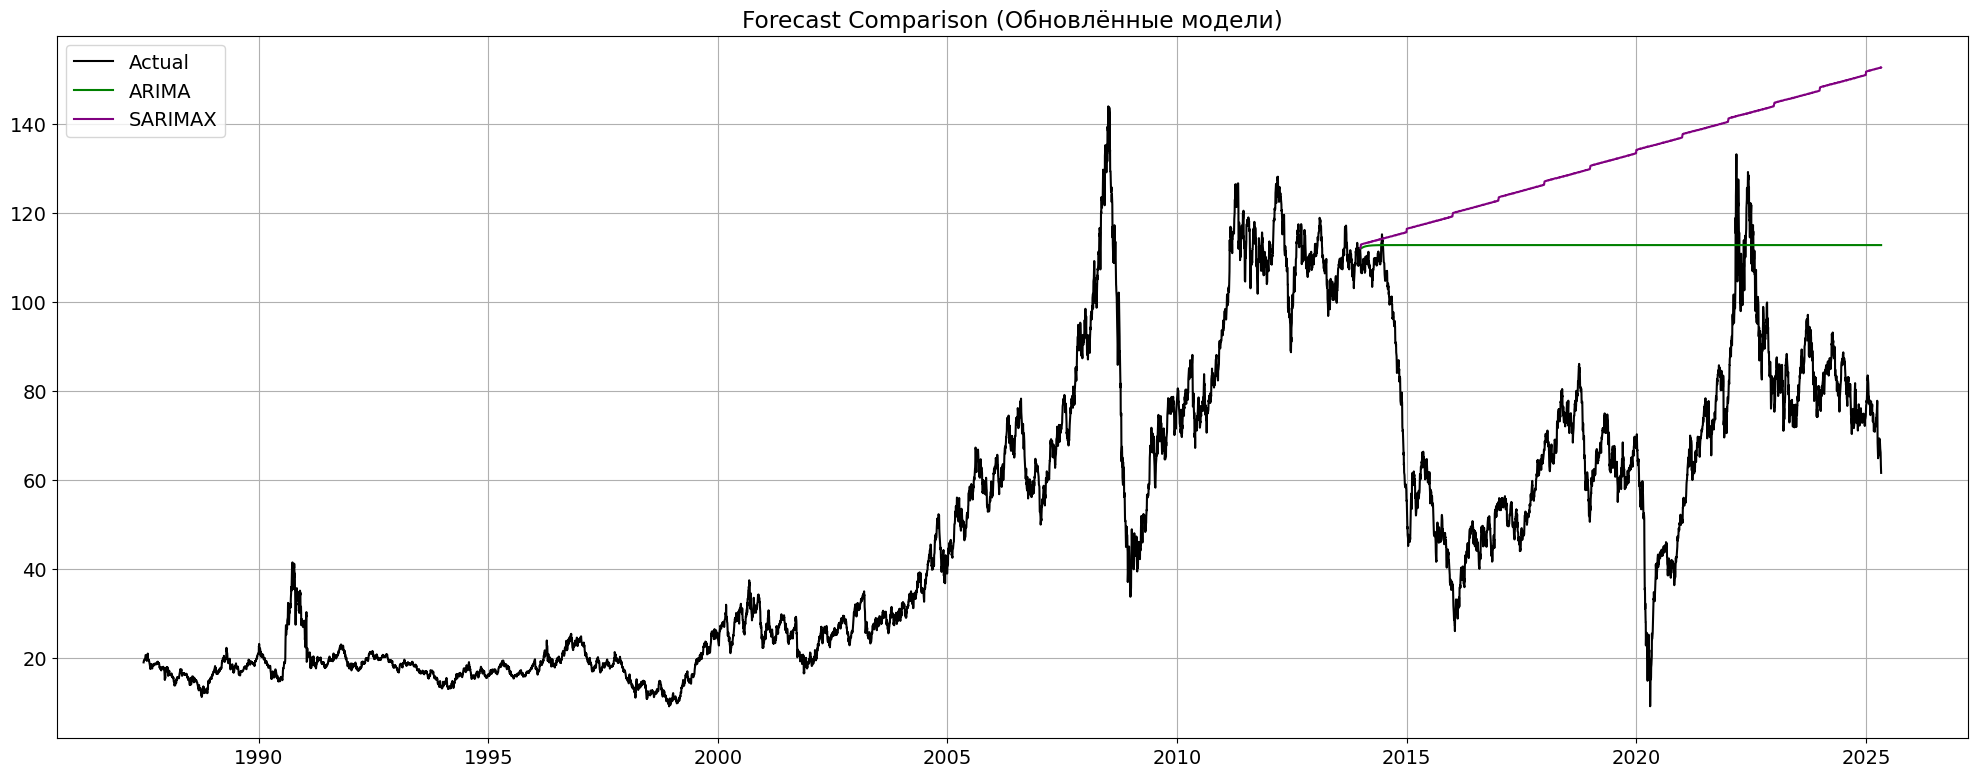

In [29]:
plt.figure(figsize=(20, 8))
plt.plot(df.index, df['Price'], label='Actual', color='black')
plt.plot(test.index, y_pred_arima, label='ARIMA', color='green')
#plt.plot(test.index, y_pred_sarima, label='SARIMA', color='red')
plt.plot(test.index, y_pred_sarimax, label='SARIMAX', color='purple')
plt.title("Forecast Comparison (Обновлённые модели)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [30]:
y_train = train['Price']
y_test = test['Price']

train_exog = train.index.month.values.reshape(-1, 1)
test_exog = test.index.month.values.reshape(-1, 1)

In [31]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Price']])

In [32]:
sequence_length = 50
X = []
y = []
for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [33]:
train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [34]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=1)

Epoch 1/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0220
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 3.1124e-04
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - loss: 2.7243e-04
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 2.5542e-04
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 2.5330e-04
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 2.4668e-04
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 2.2015e-04
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 2.1080e-04
Epoch 9/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 2.0917e-04
Epoch 10/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 1.9857e-04


In [35]:
predicted = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted.reshape(-1, 1))
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(real_prices, predicted_prices))
mae = mean_absolute_error(real_prices, predicted_prices)
r2 = r2_score(real_prices, predicted_prices)

print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"R²  : {r2:.4f}")

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
RMSE: 2.8051
MAE : 2.0241
R²  : 0.9821


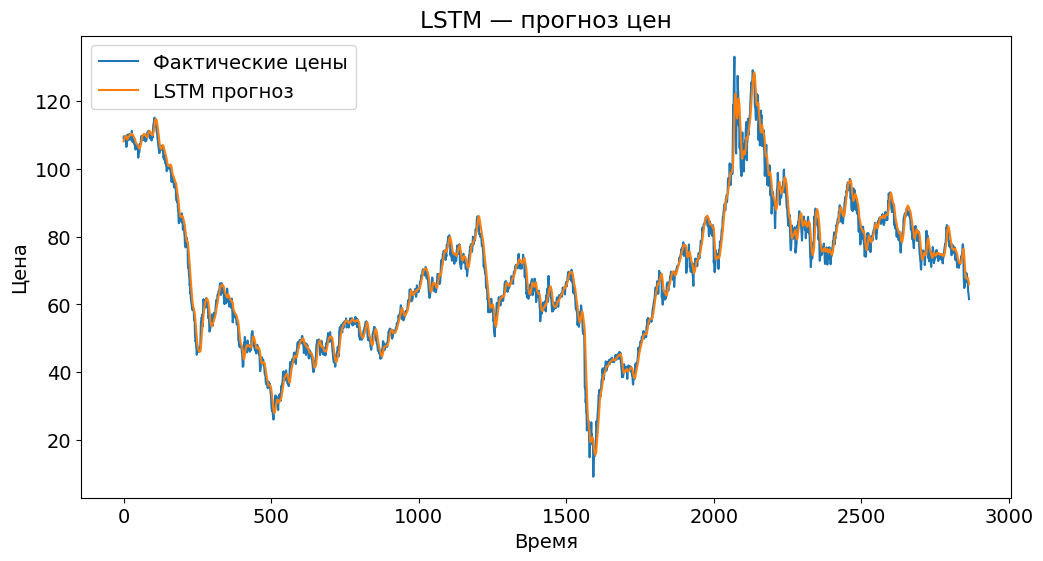

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(real_prices, label='Фактические цены')
plt.plot(predicted_prices, label='LSTM прогноз')
plt.title('LSTM — прогноз цен')
plt.xlabel('Время')
plt.ylabel('Цена')
plt.legend()
plt.show()

In [37]:
df_prophet = df.reset_index().rename(columns={"Date": "ds", "Price": "y"})

train_size = int(len(df_prophet) * 0.7)
train = df_prophet.iloc[:train_size]
test = df_prophet.iloc[train_size:]

In [38]:
model = Prophet()
model.fit(train)
future = test[['ds']].copy()
forecast = model.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpugtk1j5d/bikw5h8x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpugtk1j5d/4rn1vwj6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7747', 'data', 'file=/tmp/tmpugtk1j5d/bikw5h8x.json', 'init=/tmp/tmpugtk1j5d/4rn1vwj6.json', 'output', 'file=/tmp/tmpugtk1j5d/prophet_modelgnh0c57i/prophet_model-20250508064904.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:49:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:49:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


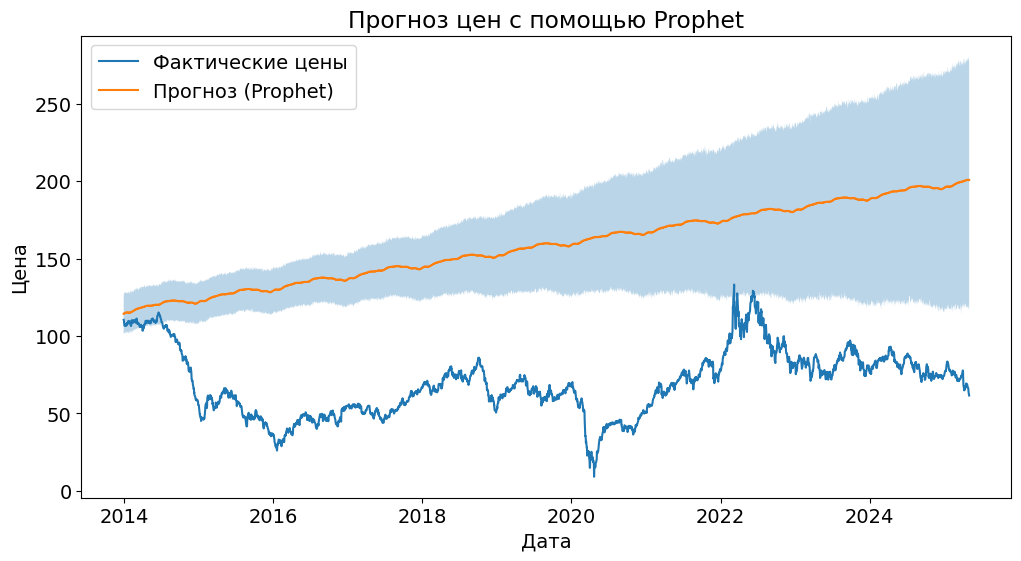

In [39]:
plt.figure(figsize=(12,6))
plt.plot(test['ds'], test['y'], label='Фактические цены')
plt.plot(forecast['ds'], forecast['yhat'], label='Прогноз (Prophet)')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], alpha=0.3)
plt.title('Прогноз цен с помощью Prophet')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.show()